# Step-by-step -- Understanding transport with fractures

This notebook aims to understand - line by line - how to solve transport on fractures. It will in detail describe every step, and how each step affects future behaviour.

# 1 Imports
We import three modules, `porepy`, `scipy` and `numpy`. These modules are always needed for porepy.

In [1]:
import porepy as pp
import scipy.sparse as sps
import numpy as np


In addition, we will import a particular set of methods used for implicitly solving time-step problems.
These are `ImplicitMassMatrix`. We need implicit variants of other discretizers too, but these must be implemented locally. These will be `ImplicitTpfa`, `ImplicitScalarSource`, `ImplicitUpwindCoupling` and `ImplicitRobinCoupling`.

In [2]:
from porepy.utils.derived_discretizations import implicit_euler as IE_discretizations

# Domain
Next, we create a simple triangular 2D domain with a single fracture.

In [3]:
def create_domain(domain):
    """ Create a 2D domain with one fracture.
    
    Returns:
    pp.GridBucket - an object containing the grids (rock and fracture).
    
    """
    eps = 0.1
    p = np.array([[0+eps, 2-eps], [0, 0]])
    e = np.array([[0], [1]])
    mesh_args = {'mesh_size_frac': 1,
                 'mesh_size_bound': 1,}
    network_2d = pp.FractureNetwork2d(p, e, domain)
    gb = network_2d.mesh(mesh_args)
    
    return gb

In [4]:
#gb = create_domain()
#for g, d in gb:
#    print("dim: ",g.dim)
#    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
#   print(b_faces)
#    print(g.face_centers[:,b_faces])
#    print('')
#    print(d)
#    print('---')
#    pp.initialize_default_data(g, d, 'transport')
#    print(d)

In [5]:
#for e, d in gb.edges():
    #print(e)
    #print('')
    #print(d)
    #print('---')
    #d[pp.PARAMETERS].update_dictionaries('flow', {})
    #d[pp.DISCRETIZATION_MATRICES]['flow'] = {}

Next, create simple boundary conditions.
Flow from left to right, with no-flow conditions on top and bottom.

The method assigns data to each grid in the `GridBucket`, i.e. rock matrix, fractures, etc.

We are able to set default parameters for `flow`, `transport` and `mechanics` using `initialize_default_data`. To see what data is being set for the problems, see pp/params/data.py and pp/params/parameter_dictionaries.py.

The parameters are stored in a class pp.Parameters. This class is itself stored in the data dictionary on each node and edge in the GridBucket, that is, in the variable `d` in the below loop.
To see which parameters are stored on each grid, see `d[pp.PARAMETERS]`.
We can store parameters for multiple problems in the dictionary. Each problem is then identified by a keyword. That keyword must also be provided to the discretization method.

In [6]:
def assign_data(gb, domain, 
                keyword_flow_storage, keyword_transport_storage):
    """ Assign data for low and transport problem
    
    Parameters
    gb (pp.GridBucket)
    domain (dict): Dictionary of domain boundaries denoted by
                    'xmin', 'xmax', 'ymin', 'ymax'
                    
    keyword_flow_storage (str): Name of where flow parameters will be
                    stored. Usually 'flow'.
    keyword_transport_storage (str): Name of where transport parameters
                    will be stored. Usually 'transport'
                            
    
    Returns
    pp.GridBucket with all the assigned data.
    """
    
    frac_perm = 1e3
    matrix_perm = 1
    
    # Assign data to the data dictionaries on each grid
    for g, d in gb:
        
        # Permeability 
        if g.dim == gb.dim_max():
            kxx = matrix_perm * np.ones(g.num_cells)
        else:
            kxx = frac_perm * np.ones(g.num_cells)
        perm = pp.SecondOrderTensor(kxx)
        
        # Next, boundary conditions
        b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        #bc_val = 0 will be applied both to the 2D grid and 1D fracture.
        
        tol=1e-4
        # However, only grids with faces on the global boundary will
        # have assigned boundary conditions
        # (i.e. if a fracture lies on the boundary, it will get boundary
        # conditions assigned.)
        if b_faces.size != 0:
            
            b_face_centers = g.face_centers[:, b_faces]
            
            # Locate boundaries
            left = b_face_centers[0,:] < domain['xmin'] + tol
            right = b_face_centers[0, :] > domain['xmax'] - tol
            
            # Create an array of labels of size = number of boundary faces.
            labels = np.array(['neu'] * b_faces.size)
            labels[np.logical_or(left, right)] = 'dir'
            bc = pp.BoundaryCondition(g, b_faces, labels)
            
            # On the dirichlet left (inflow) boundary, set its value:
            bc_val[b_faces[left]] = 1
            
        else:  # if the entire grid contains no boundary faces.
            bc = pp.BoundaryCondition(g)  # Default conditions.
        
        
        # Assign data to the two problems, flow and transport.
        params_flow = {'second_order_tensor': perm,
                       'bc': bc,
                       'bc_values': bc_val,
                        }
        pp.initialize_default_data(g, d, 'flow', params_flow,
                                  keyword_flow_storage)
        
        # For implicit euler, the upwind discretization needs an
        # 'advection_weight'
        w = 1
        params_transport = {'bc': bc,
                            'bc_values': bc_val,
                            'advection_weight': w,
                            }
        pp.initialize_default_data(g, d, 'transport', params_transport,
                                  keyword_transport_storage)
        
        # Store the dimension in the dictionary for visualization purposes
        d[pp.STATE] = {"dimension": g.dim * np.ones(g.num_cells)}
            
    for e, d in gb.edges():

        # Add some required data for fracture problems, which
        # is not possible to automatically initialize.
        
        # The robin coupling (diffusion) needs normal_diffusivity.
        # the upwind coupling (advection) has no edge parameters
        data = {'normal_diffusivity': 2e1}
        d[pp.PARAMETERS] = pp.Parameters(keywords=[keyword_flow_storage,
                                                  keyword_transport_storage
                                                  ],
                                        dictionaries=[data,
                                                      data,
                                                      ])
        # Initialize discretization matrices dictionary
        d[pp.DISCRETIZATION_MATRICES] = pp.Parameters(keywords=[keyword_flow_storage,
                                                               keyword_transport_storage
                                                               ],
                                                     dictionaries=[{}, {}])
    
    return gb

# Set up the grid and data

In this notebook, we are solving two PDEs separately. First, the pressure diffusion equation, then the tracer transport problem.

Pressure diffusion:
$$ - \nabla \cdot (K\nabla p) = 0$$

Tracer transport:
$$\rho C \frac{\partial T}{\partial t} + \mathbf{v} \cdot \nabla T - \nabla \cdot (K_T \nabla T) = 0$$

To set up this problem properly in porepy, consider first the pressure diffusion equation. To let porepy understand how to assign the permeability $K$ to the term $-\nabla \cdot (K \nabla p)$, we assign some data to the type of problem we are solving.

# THIS NEEDS TO BE UPDATED
#### Flow
This class of problem is called `flow`. We set the keyword `kw_f = flow` in order to easily generate default data for the problem, and ensure that the discretization operators behave properly (i.e. include the $K$ term in the discretization matrix, the correct boundary conditions, etc.).
The data itself will be stored in `data[pp.PARAMETERS][variable_f]`, where  `variable_f` could be for instance `pressure`. Similarly, the discretization matrices are stored in `data[pp.DISCRETIZATION_MATRICES][variable_f]`.

Next, we give a keyword to the variable we are solving for: `pressure`, by letting `variable_f = pressure`. This keyword will for instance be used to navigate to the right state in `data[pp.STATE][...]`, where `...` would be `'pressure'` in this case.

For the coupling between grids, we designate `mv_f_diffusion = 'mortar_flow_diffusion'` to the pressure diffusion problem.
This keyword is used in:
* Keyword for parameter dictionary on edges (containing "normal_diffusivity)
* Keyword when initializing edge couplings
* Keyword for discretization matrices on edges.

---
#### Tracer transport
Consider the tracer transport equation.
This problem is in the class `transport`. We let `kw_t = 'transport'`, and use `kw_t` when initializing data or discretization operators.
Data and operators will be stored under the keyword `variable_t = 'tracer'`.

The transport equation consists of an advective term and possibly a diffusive term. These terms needs to be handled by separate coupling terms physically. To accomodate this, we designate `mv_t_advection = 'mortar_transport_advection'` for the advective term, and `mv_t_diffusion = 'mortar_transport_diffusion'` for the diffusive term.
These keywords are used in:
* Keyword for parameter dictionary on edges (containing "normal_diffusivity)
* Keyword when initializing edge couplings
* Keyword for discretization matrices on edges.

In [7]:
# Keywords for initializing correct parameters.
flow_keyword = 'flow'
transport_keyword = 'transport'

# Variables for our particular problem. 
# These variables are keywords for everything related to these parameters:
# --- discretization matrices, current state, parameters, etc.
flow_variable = 'pressure'
transport_variable = 'tracer'

# Operator keys:
flow_operator_key = 'diffusion'

advection_operator_key = 'advection'
mass_operator_key = 'mass'
diffusion_operator_key = 'diffusion_tracer'

In [8]:
# Set up the domain and assign data
domain={'xmin': 0, 'xmax': 2, 'ymin': -1, 'ymax': 1}
gb = create_domain(domain=domain)
gb = assign_data(gb, domain=domain,
                keyword_flow_storage=flow_keyword,
                keyword_transport_storage=transport_keyword,
                )

# Initial conditions for tracer:
for g, d in gb:
    t_0 = np.zeros(g.num_cells)
    state = {transport_variable: t_0}
    pp.set_state(d, state)

##### Discretization objects for pressure diffusion
Create discretization objects for grid and coupling conditions for the pressure diffusion problem

For the diffusion term, a `RobinCoupling` is used.
This class needs the keyword for the diffusion term in the mortar grid, `mv_f_diffusion` and the discretization objects for the master and slave grids. Here, I use the same discretization on all grids, i.e. `tpfa_flow`.

In [9]:
# Pressure diffusion discretization
flow_discretization = pp.Tpfa(flow_keyword)
# Coupling:
edge_discretization_flow = pp.RobinCoupling(flow_keyword, 
                                            flow_discretization, 
                                            flow_discretization)

# Variable name for the interface variable
edge_variable_flow = 'darcy_flux'
# Name for the discretization operator for the coupling term.
coupling_operator_key_flow = 'darcy_flux'

##### Discretization objects for tracer advection-diffusion
For the transport problem, since it is time-dependent, we need to modify several of the discretization objects to conform to a certain way of solving the implicit problem.

Essentially, we may consider a time-dependent system, 
$$\frac{\partial u}{\partial t} = F(u)$$
which we want to solve using backward euler:
$$\frac{u^{t + \Delta t} - u^{t}}{\Delta t} = F(u^{t + \Delta t})$$
we can re-order the terms:
$$u^{t + \Delta t} - \Delta t F(u^{t + \Delta t}) = u^{t}$$
let $x=u^{t + \Delta t}$ and $b = u^{t}$:
$$x + \Delta t F x = b$$

We see that every term except the previous time step needs to be multiplied by $\Delta t$.
Here, the operator $F$ will consist of the discretization objects for the advective term, diffusive term, etc.

To assemble this system, we would like to multiply the appropriate terms by $\Delta t$. This is done by overriding the methods in the discretization operators that we will use.

Consider
$$\rho C \frac{\partial T}{\partial t} + \mathbf{v} \cdot \nabla T - \nabla \cdot (K_T \nabla T) = 0$$

* `mass_term`: $\rho C \frac{\partial T}{\partial t}$, use: `ImplicitMassMatrix`
* `advection_term`: $\mathbf{v} \cdot \nabla T$, use: `ImplicitUpwind`
* `diffusion_term`: $- \nabla \cdot (K_T \nabla T)$, use: `ImplicitTpfa`

In [10]:
# Override methods for implicit time-stepping:
class ImplicitTpfa(pp.Tpfa):
    """
    Multiply all contributions by the time step.
    """

    def assemble_matrix_rhs(self, g, data):
        """ Overwrite TPFA method to be consistent with the Biot dt convention.
        """
        a, b = super().assemble_matrix_rhs(g, data)
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]
        a = a * dt
        b = b * dt
        return a, b

    def assemble_int_bound_flux(
        self, g, data, data_edge, grid_swap, cc, matrix, rhs, self_ind
    ):
        """
        Overwrite the TPFA method to be consistent with the Biot dt convention
        """
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]

        div = g.cell_faces.T

        bound_flux = data[pp.DISCRETIZATION_MATRICES][self.keyword]["bound_flux"]
        # Projection operators to grid
        mg = data_edge["mortar_grid"]

        if grid_swap:
            proj = mg.mortar_to_slave_int()
        else:
            proj = mg.mortar_to_master_int()

        if g.dim > 0 and bound_flux.shape[0] != g.num_faces:
            # If bound flux is gven as sub-faces we have to map it from sub-faces
            # to faces
            hf2f = pp.fvutils.map_hf_2_f(nd=1, g=g)
            bound_flux = hf2f * bound_flux
        if g.dim > 0 and bound_flux.shape[1] != proj.shape[0]:
            raise ValueError(
                """Inconsistent shapes. Did you define a
            sub-face boundary condition but only a face-wise mortar?"""
            )

        cc[self_ind, 2] += dt * div * bound_flux * proj
    
    def assemble_int_bound_source(
        self, g, data, data_edge, grid_swap, cc, matrix, rhs, self_ind
    ):
        """ Abstract method. Assemble the contribution from an internal
        boundary, manifested as a source term.
        The intended use is when the internal boundary is coupled to another
        node in a mixed-dimensional method. Specific usage depends on the
        interface condition between the nodes; this method will typically be
        used to impose flux continuity on a lower-dimensional domain.
        Implementations of this method will use an interplay between the grid on
        the node and the mortar grid on the relevant edge.
        Parameters:
            g (Grid): Grid which the condition should be imposed on.
            data (dictionary): Data dictionary for the node in the
                mixed-dimensional grid.
            data_edge (dictionary): Data dictionary for the edge in the
                mixed-dimensional grid.
            grid_swap (boolean): If True, the grid g is identified with the @
                slave side of the mortar grid in data_adge.
            cc (block matrix, 3x3): Block matrix for the coupling condition.
                The first and second rows and columns are identified with the
                master and slave side; the third belongs to the edge variable.
                The discretization of the relevant term is done in-place in cc.
            matrix (block matrix 3x3): Discretization matrix for the edge and
                the two adjacent nodes.
            rhs (block_array 3x1): Right hand side contribution for the edge and
                the two adjacent nodes.
            self_ind (int): Index in cc and matrix associated with this node.
                Should be either 1 or 2.
        """
        mg = data_edge["mortar_grid"]

        if grid_swap:
            proj = mg.mortar_to_master_int()
        else:
            proj = mg.mortar_to_slave_int()
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]
        cc[self_ind, 2] -= proj * dt

Next, we create the discretization objects for advection-diffusion:

In [11]:
# Discretization objects

# First argument, keyword, is where to get parameters from
# and store discretization matrices to.
# Second argument, variable, is where the previous state (d[pp.STATE][variable]) is stored.
mass_discretization = IE_discretizations.ImplicitMassMatrix(keyword=transport_keyword,
                                                            variable=transport_variable)

# Here, we might need to define,
# data[pp.PARAMETERS][variable_t]['advection_weight'] ...
advection_discretization = IE_discretizations.ImplicitUpwind(transport_keyword)

diffusion_discretization = ImplicitTpfa(transport_keyword)

# ----
# EDGE discretizations
# the first arg is where to get parameters from and store discretization matrices to
# Second and third args are master and slave discretizations, respectively.
edge_discretization_transport_diffusion = pp.RobinCoupling(transport_keyword,
                                                           diffusion_discretization,
                                                           diffusion_discretization)
# Variable name for the interface variable
edge_variable_transport_diffusion = 'edge_diffusion'
# Name for the discretization operator for the coupling term
coupling_operator_key_diffusion = 'coupling_operator_transport_diffusion'

edge_discretization_transport_advection = IE_discretizations.ImplicitUpwindCoupling(transport_keyword)

edge_variable_transport_advection = 'edge_advection'
coupling_operator_key_advection = 'coupling_operator_transport_advection'

#### Distribute the discretization objects

The various discretization objects needs to be added to the grid bucket.

In [12]:
for g, d in gb:
    
    # Assign primary variables on the grid
    d[pp.PRIMARY_VARIABLES] = {
        flow_variable: {"cells": 1, "faces": 0},
        transport_variable: {"cells": 1, "faces": 0},
    }
    
    # Assign discretization operators for each variable
    d[pp.DISCRETIZATION] = {
        flow_variable: {
            flow_operator_key: flow_discretization,
        },
        transport_variable: {
            mass_operator_key: mass_discretization,
            advection_operator_key: advection_discretization,
            diffusion_operator_key: diffusion_discretization
        }
    }

    for e, d in gb.edges():
        g1, g2 = gb.nodes_of_edge(e)
        d[pp.PRIMARY_VARIABLES] = {
            edge_variable_flow: {"cells": 1},
            edge_variable_transport_diffusion: {"cells": 1},
            edge_variable_transport_advection: {"cells": 1}
        }
        
        d[pp.COUPLING_DISCRETIZATION] = {
            coupling_operator_key_flow: {
                g1: (flow_variable, flow_operator_key),
                g2: (flow_variable, flow_operator_key),
                e: (edge_variable_flow, edge_discretization_flow)
            },
            coupling_operator_key_diffusion: {
                g1: (transport_variable, diffusion_operator_key),
                g2: (transport_variable, diffusion_operator_key),
                e: (edge_variable_transport_diffusion, edge_discretization_transport_diffusion)
            },
            coupling_operator_key_advection: {
                g1: (transport_variable, advection_operator_key),
                g2: (transport_variable, advection_operator_key),
                e: (edge_variable_transport_advection, edge_discretization_transport_advection)
            }
        }

## Assembler for flow and transport problem
To exclusively solve the flow problem (we need the darcy flux to solve the transport problem), we use a filter on the assembler.

We set up two assemblers, one for each problem.

In [13]:
assembler_flow = pp.Assembler(gb, active_variables=[
                                    flow_variable, 
                                    edge_variable_flow
                                                    ])

assembler_transport = pp.Assembler(gb, 
                                   active_variables=[
                                       transport_variable,
                                       edge_variable_transport_diffusion,
                                       edge_variable_transport_advection,
                                                    ])

## First, solve the flow problem

In [14]:
assembler_flow.discretize()
A_flow, b_flow = assembler_flow.assemble_matrix_rhs()
pressure = sps.linalg.spsolve(A_flow, b_flow)
assembler_flow.distribute_variable(pressure)

Next, compute the flux field and make this information available to the transport solver.

In [15]:
pp.fvutils.compute_darcy_flux(gb, lam_name='darcy_flux', keyword_store=transport_keyword)

Export the solutions

In [16]:
exporter_pressure = pp.Exporter(gb, name='flow', folder='advection_diffusion')
exporter_pressure.write_vtk(flow_variable)

/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


## Next, solve the transport problem

In [17]:
assembler_transport.discretize()

# Test the first time-step:
#A_transport, b_transport = assembler_transport.assemble_matrix_rhs()
#tracer = sps.linalg.spsolve(A_transport, b_transport)
# Distributing variable changes the state.
#assembler_transport.distribute_variable(tracer)

In [18]:
# Time stepping
dt = 0.1
time = 0
end_time = 3

Set a new exporter for the transport problem. 

Make a list of time steps to visualize the time evolution of tracer.

In [19]:
export_transport = pp.Exporter(gb, name='tracer', folder='advection_diffusion')

time_steps = []

export the initial state (initial conditions set at beginning of script)

In [20]:
export_transport.write_vtk('tracer', time_step=time)
time_steps.append(time)

Finally, use backward euler for time stepping

In [21]:
while time < end_time - 1e-10:
    A_transport, b_transport = assembler_transport.assemble_matrix_rhs()
    tracer = sps.linalg.spsolve(A_transport, b_transport)
    
    # increase time
    time += dt
    time_steps.append(time)
    
    # Distribute and export
    assembler_transport.distribute_variable(tracer)
    export_transport.write_vtk('tracer', time_step=time)
    
# Export the time history as a separate file.
# This will produce a file 'tracer.pvd', which should be used for visualization
time_steps = np.asarray(time_steps)
export_transport.write_pvd(time_steps) 

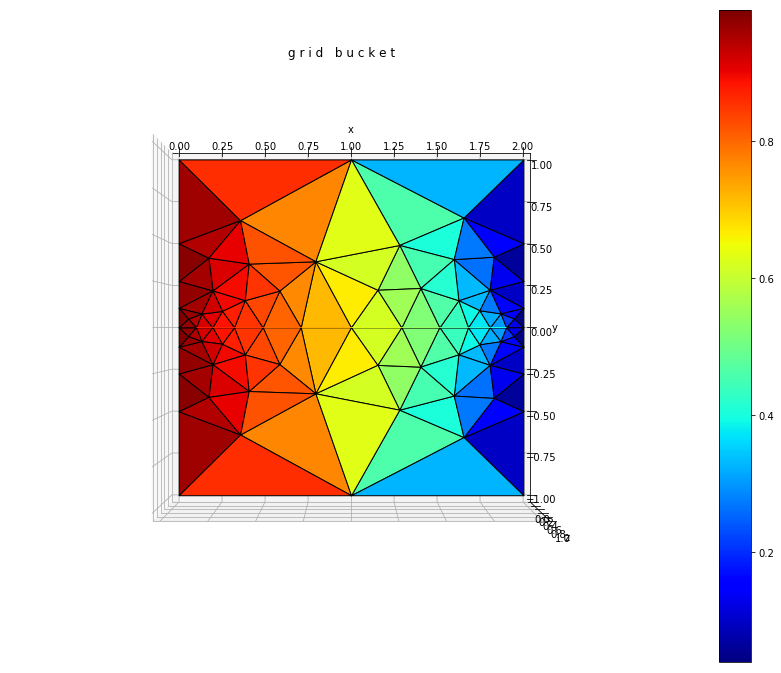

In [22]:
pp.plot_grid(gb, transport_variable, figsize=(15,12))